In [1]:
import torch
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
from custom_data_loader import *
split = "train"
name = "mnist"
batch_size = 64

train_set = custom_data_loader(split_name=split, name=name, batch_size=batch_size)

mnist_train was loaded
running on CPU but cuda is available.


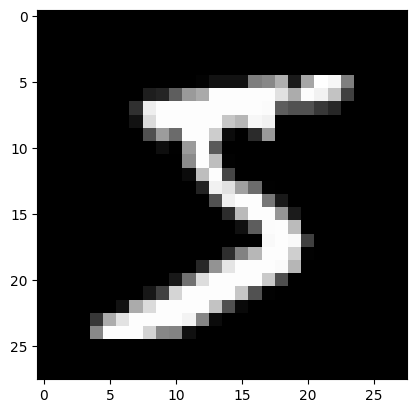

In [3]:
x = train_set.x
x = x.squeeze()
x = t.reshape(x,  x.shape[:1] + tuple([-1])).numpy()
plt.imshow(x[0,:].reshape(28,28), cmap='gray')#, vmin=0, vmax=1)

In [4]:
# working but gives very poor results
def zca_whitening(x, eps = 0.001):

    sigma = np.cov(x, rowvar=False)
    U,S,V = np.linalg.svd(sigma)
    ZCAMatrix = U @ np.diag(1.0/np.sqrt(S + eps)) @ U.T
    return ZCAMatrix

#train_set = custom_data_loader(split_name=split, name=name, batch_size=batch_size)
train_set.x = train_set.x.squeeze()
train_set.x = t.reshape( train_set.x,   train_set.x.shape[:1] + tuple([-1])).numpy().astype(np.float64) -0.5

print(train_set.x.shape)
print(len(train_set))
print("min and max", train_set.x.min(), train_set.x.max())


(60000, 784)
60000
min and max -0.5 0.5


In [5]:
    
def plot_(diff, err):
    fig = plt.figure(figsize=(10,5))
    fig.add_subplot(1, 2, 1)
    plt.plot(diff)
    plt.yscale("log")
    plt.title("l2 change of z (sparse code)")
    
    fig.add_subplot(1, 2, 2)
    plt.plot(err)
    plt.yscale("log")
    plt.title("l2 err")
    plt.show()
    return 




In [6]:
def plot_W_and_reconst(W, sparse_codes, x_batch, num_plots = 5, seed=None):
    np.random.seed(seed)
    W_n, W_m = W.shape
    res = int(np.sqrt(W_n))
    assert res**2 == W_n
    f, ax = plt.subplots(num_plots, num_plots+1 )
    f.set_figheight(15)
    f.set_figwidth(15)
    plt.tight_layout()
    for ax1 in range(num_plots):
        for ax2 in range(num_plots):
            rand_int = np.random.randint(0,W_m-1)
            ax[ax1, ax2].imshow(W[:,rand_int].reshape(res,res), cmap='gray', vmin=-0.5, vmax=0.5)
            ax[ax1, ax2].set_title("W col "+str(rand_int))
            ax[ax1, ax2].axis('off')

    if x_batch.ndim == 1:
        x = x_batch
    else:
        x = x_batch[0,:]
    ax[0, -1].imshow(x.reshape(28,28), cmap='gray')
    ax[0, -1].set_title("some true x")
    ax[1, -1].imshow((W@sparse_codes[0,:]).reshape(28,28), cmap='gray')
    ax[1, -1].set_title("x reconstruc")
    
    if x_batch.ndim > 1:
        ax[2, -1].imshow(x_batch[1,:].reshape(28,28), cmap='gray')
        ax[2, -1].set_title("some true x")
        ax[3, -1].imshow((W@sparse_codes[1,:]).reshape(28,28), cmap='gray')
        ax[3, -1].set_title("x reconstruc")
        
    ax[0, -1].axis('off')
    ax[1, -1].axis('off')
    ax[2, -1].axis('off')
    ax[3, -1].axis('off')
    ax[4, -1].axis('off')
    
    plt.show()

In [7]:
def print_batch_info(epoch, batch_num, momentum, batch_err, batch_size, sparse_codes):
    zero_elements = np.mean(sparse_codes==0)
    print(f"e: {epoch}, b: {batch_num}, momen: {momentum:.2f}, "
          f"spar: {zero_elements:.3f}, rec err: {batch_err / batch_size:.2f}, "
          f"err/spar: {(batch_err/batch_size) / zero_elements:.2f}")

In [27]:
def compute_A_and_B(sparse_code, train_data):
    A = sparse_code.T @ sparse_code
    B = train_data.T @ sparse_code
    return A, B

def update_W(A, B, W):
    n_attr, n_cols = A.shape
    W_new = W.copy() # to not overwrite the or
    
    for j in range(n_cols):
        val = W[:, j] + (1/A[j,j]) * (B[:,j] - W @ A[:, j])
        val_normed = val / max(np.sqrt(np.sum(val**2)), 1)
        W_new[:, j] = val_normed

    return W_new

In [28]:
from ista_fista_cod import fista, CoD, ista
from joblib import Parallel, delayed
n, m = train_set.x.shape

code_basis_vectors = m
#sparse_codes = np.zeros((code_basis_vectors, n))
W = np.random.normal(size=(m, code_basis_vectors)) # generate random ones
#W = np.copy(train_set.x[:m,:].T) # or use first training examples
#W = torch.load("W_learned_baseline.pt").numpy() # load trained ones
W = W / np.sqrt(np.sum(W**2, axis=0))[None,:] # normalize

A_velocity = np.random.normal(size=(code_basis_vectors, code_basis_vectors) )*0.01   
B_velocity = np.random.normal(size=(m, code_basis_vectors))*0.01  
velocity = np.zeros_like(W)

print("W shape:", W.shape)

W shape: (784, 784)


In [29]:
import tqdm
alpha = 0.5
nsteps = 300
epochs = 100
batch_size = 100
train_set.set_batch_size(batch_size)
momentum = 0.9
momentum_max = 0.95
momentum_batch_inc = 0.01
actually_plot = False
plot_every_n = max(int(200/batch_size), 1)
lr = 0.01
sparse_code_func = CoD
method = 2
for epoch in range(epochs):
    for batch_num, (x_batch, y_batch) in enumerate(train_set):
        momentum = min(momentum+momentum_batch_inc, momentum_max)
        batch_err = 0.
        sparse_codes = np.zeros((batch_size, code_basis_vectors))
        for j in range(x_batch.shape[0]):
            sparse_codes[j,:], _, _, final_error, _, _ = sparse_code_func(W=W, 
                                                                          x=x_batch[j,:] , 
                                                                          alpha=alpha, 
                                                                          nsteps=nsteps, 
                                                                          verbose=False)             
            batch_err += final_error
        
        # works but isnt faster
        # results = Parallel(n_jobs=6)(delayed(sparse_code_func)
        #                              (W.copy(), x_batch[j,:].copy(), alpha, nsteps, False) for j in range(batch_size))
        # 
        # sparse_codes = np.vstack([results[j][0] for j in range(batch_size)])
        # x_batch = np.vstack([results[j][5] for j in range(batch_size)])
        # batch_err = sum([results[j][3] for j in range(batch_size)])
            
        print_batch_info(epoch, batch_num, momentum, batch_err, batch_size, sparse_codes)
        if batch_num % plot_every_n == 0 and actually_plot:
            _, diff, err, _, _, _ = sparse_code_func(W=W, 
                                                     x=x_batch[0,:] , 
                                                     alpha=alpha, 
                                                     nsteps=nsteps, 
                                                     verbose=True)
            plot_(diff, err)
            plot_W_and_reconst(W, sparse_codes, x_batch, num_plots = 5, seed=None)

        if method==1: #coord_descent:
            A, B = compute_A_and_B(sparse_codes, x_batch)
            A_velocity = momentum * A_velocity + A
            B_velocity = momentum * B_velocity + B
            W = update_W(A_velocity, B_velocity, W)
            
        if method==2: #manual gradient descent 
            grad = -(x_batch - (W@sparse_codes.T).T).T @ sparse_codes 
            #dims:              (batch, att)    @   (att, spar) @ (batch, spar) 
            # this line above does the loop below
            # for k in range(batch_size):
            #     grad += np.outer((x_batch[k,:] - W@sparse_codes[k,:]), sparse_codes[k,:])
            grad /= batch_size # calc avg
            velocity = momentum*velocity + grad
            W -= lr * velocity # perform update
            W /= np.sqrt(np.sum(W**2, axis=0))[None,:] # renormalize


e: 0, b: 0, momen: 0.91, spar: 0.782, rec err: 11.09, err/spar: 14.18
e: 0, b: 1, momen: 0.92, spar: 0.785, rec err: 9.88, err/spar: 12.59
e: 0, b: 2, momen: 0.93, spar: 0.822, rec err: 8.09, err/spar: 9.84
e: 0, b: 3, momen: 0.94, spar: 0.869, rec err: 6.99, err/spar: 8.04
e: 0, b: 4, momen: 0.95, spar: 0.897, rec err: 6.77, err/spar: 7.54
e: 0, b: 5, momen: 0.95, spar: 0.911, rec err: 6.76, err/spar: 7.42
e: 0, b: 6, momen: 0.95, spar: 0.915, rec err: 6.95, err/spar: 7.59
e: 0, b: 7, momen: 0.95, spar: 0.924, rec err: 6.81, err/spar: 7.37
e: 0, b: 8, momen: 0.95, spar: 0.930, rec err: 6.76, err/spar: 7.27
e: 0, b: 9, momen: 0.95, spar: 0.934, rec err: 6.66, err/spar: 7.13
e: 0, b: 10, momen: 0.95, spar: 0.941, rec err: 6.43, err/spar: 6.83
e: 0, b: 11, momen: 0.95, spar: 0.940, rec err: 6.41, err/spar: 6.82
e: 0, b: 12, momen: 0.95, spar: 0.943, rec err: 6.22, err/spar: 6.60
e: 0, b: 13, momen: 0.95, spar: 0.943, rec err: 6.20, err/spar: 6.57
e: 0, b: 14, momen: 0.95, spar: 0.941, re

KeyboardInterrupt: 

In [ ]:
all_data = train_set.x
sparse_codes_to_save = np.zeros_like(all_data)
for j in tqdm.tqdm(range(all_data.shape[0])):
    sparse_codes_to_save[j,:], _, _, final_error, time_, _ = sparse_code_func(W=W, 
                                                                              x=all_data[j,:] , 
                                                                              alpha=alpha, 
                                                                              nsteps=nsteps, 
                                                                              verbose=False)
    
torch.save(torch.from_numpy(sparse_codes_to_save), "W_generated_sparse_code_mnist.pt")
torch.save(torch.from_numpy(W), "W_learned.pt")